**CAPSTONE PROJECT MODULE 2**

JCAIEAH-002 - ANINTYO HERDADI

# **California Housing Price**

**Content**


1.   Business Problem
2.   Data Understanding
1.   Data Preprocessing
2.   Modelling
1.   Conclusion
2.   Recommendation

Source data: [data_california_house.csv](https://drive.google.com/file/d/1NJ7DsgZ3zIdZWTz17RQWgbtDBuk1JVg3/view?usp=drive_link)

# 1. Business Problem


**Latar Belakang**

Pasar perumahan California merupakan salah satu pasar properti paling kompleks dan mahal di Amerika Serikat. Dengan populasi lebih dari 39 juta jiwa, keragaman geografis yang luas (dari pantai hingga gunung), dan variasi tingkat ekonomi membuat penentuan harga rumah yang akurat menjadi tantangan bagi pihak penjual dan pembeli.

**Rumusan Masalah**

Tantangan yang dihadapi adalah bagaimana cara memprediksi median harga rumah disuatu distrik di California secara akurat dan efisien berdasarkan karateristik geografi, demografis dan properti yang tersedia.

**Tujuan**

Berdasarkan permasalahan tersebut, maka dibutuhkan model machine learning yang dapat memprediksi median harga rumah di distrik California dengan akurasi yang tinggi. Hal ini dapat membantu penjual dan pembeli dalam negosiasi jual beli rumah yang fair.

# 2. Data Understanding



*   Dataset berdasarkan informasi dari sensus California tahun 1990
*   Setiap baris berkaitan dengan rumah-rumah yang ditemukan di distrik tertentu di California dengan beberapa statistik ringkasan berdasarkan data sensus tahun 1990.

## Import Library

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error,mean_absolute_error,root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

import warnings
warnings.filterwarnings('ignore')


## Load Data

In [19]:
# Load dataset

df = pd.read_csv('/content/drive/MyDrive/Purwadhika/Capstone_M2/data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


In [20]:
df.shape

(14448, 10)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


## Distribusi median_house_value / Target

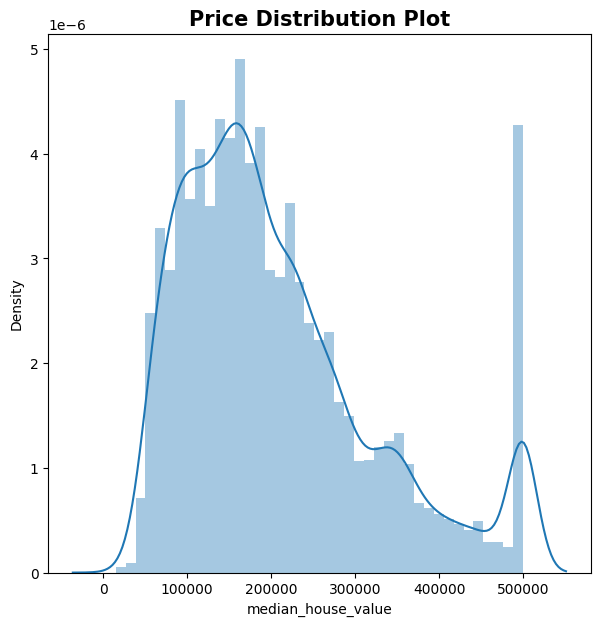

In [22]:
# Plot distribusi fitur 'median_house_value'
plt.figure(figsize=(7, 7))
sns.distplot(df['median_house_value'])
plt.title('Price Distribution Plot', size=15, weight='bold');

Berdasarkan plot distribusi 'median_house_value' di atas terlihat bahwa terdapat 'right-skewed distribution'. Dengan kata lain, terdapat skewness positif pada fitur price.

Plot distribusi juga menunjukkan adanya dua puncak, yaitu disebelah kanan yang menunjukkan density yang tinggi untuk nilai rumah 500000. Perlu ditelaah lebih lanjut apakah data ini aktual atau anomali.

In [23]:
# Cek median house value untuk area 'ocean_proximity'
df_median_value_ocean_proximity = df.groupby(by=['ocean_proximity']).agg({'median_house_value':'median'}).reset_index()
df_median_value_ocean_proximity = df_median_value_ocean_proximity.set_index('ocean_proximity')
df_median_value_ocean_proximity = df_median_value_ocean_proximity.sort_values('median_house_value', ascending =False)
df_median_value_ocean_proximity.head()

,median_house_value
ocean_proximity,
ISLAND,351100.0
NEAR BAY,230800.0
NEAR OCEAN,228600.0
<1H OCEAN,214800.0
INLAND,108800.0


Berdasarkan pengecekan nilai median dari 'median_house_value' untuk kategori daerah 'ocean_proximity' atau 'kedekatan dengan laut' maka data di atas menunjukkan bahwa median_house_value tertinggi adalah rumah-rumah yang berlokasi semakin dekat laut atau pantai. Dan median_house_value terendah adalah di daratan.

In [24]:
# Correlation dengan target (median_house_value)
numeric_df = df.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['median_house_value'].sort_values(ascending=False)
print(correlations)


median_house_value    1.000000
median_income         0.693273
total_rooms           0.131972
housing_median_age    0.103863
households            0.061581
total_bedrooms        0.045915
population           -0.026183
longitude            -0.045777
latitude             -0.143957
Name: median_house_value, dtype: float64


Berdasarkan pengecekan correlation di atas, maka hubungan terkuat dengan nilai median_house_value adalah fitur median_income. Hal ini menunjukkan bahwa nilai rumah sangat berpengaruh dengan nilai pendapatan.

# 3. Data Preprocessing

In [25]:
df.isnull().sum().sort_values(ascending=False)

,0
total_bedrooms,137
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


In [26]:
# Imputasi nilai numerik dengan median
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

# Cek ulang hasilnya
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


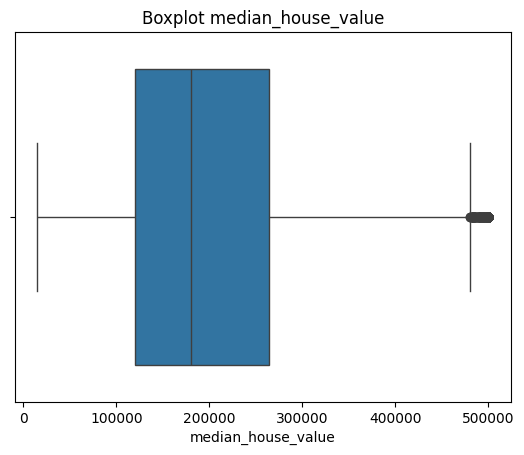

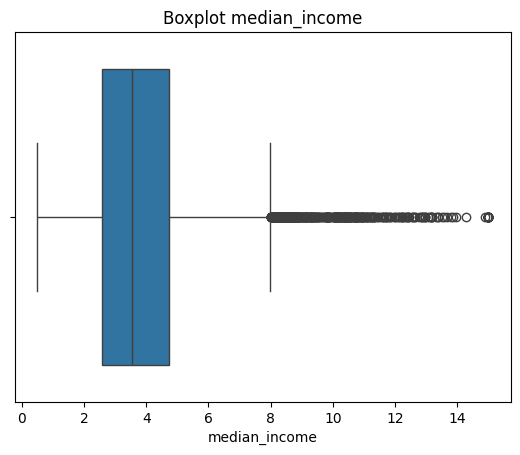

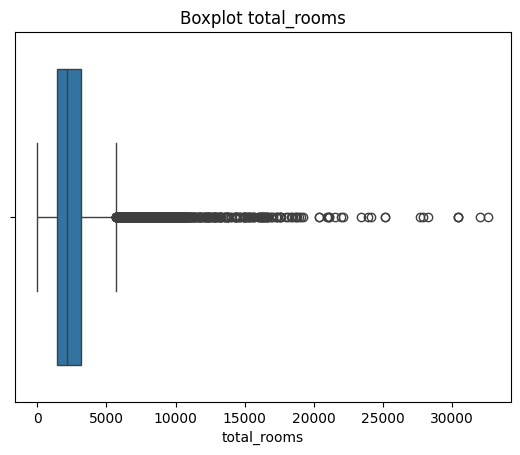

(12726, 10)

In [27]:
cols_to_check = ['median_house_value', 'median_income', 'total_rooms']
for col in cols_to_check:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

Q1 = df[cols_to_check].quantile(0.25)
Q3 = df[cols_to_check].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cols_to_check] < (Q1 - 1.5 * IQR)) | (df[cols_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

# 4. Modelling

## Split Train & Test

Data dipisah dengan komposisi 80 % training dan 20 % testing.

Tujuannya untuk mengetahui seberapa baik model bekerja pada data baru.

Random_state digunakan agar hasil tetap konsisten saat diulang

In [30]:
# Pisahkan fitur & target
X = df[['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']]
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Model

In [31]:
# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

Model Linear Regression akan mengasumsikan bahwa hubungan antara fitur dan median_house_value itu linear — garis lurus.

In [32]:
# Random Forest
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Model kedua adalah Random Forest Regressor — model ensemble yang terdiri dari banyak pohon keputusan. Random Forest membuat banyak pohon kecil, lalu rata-ratanya menjadi hasil akhir.

In [41]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

Model ketiga adalah Gradient Boosting Regressor - Algoritma ensemble yang membangun banyak decision trees secara
BERURUTAN, dimana setiap tree baru fokus memperbaiki kesalahan
tree sebelumnya

## Evaluate Models

Selanjutnya perbandingan performa kedua model menggunakan metrik regression: MAE,MAPE, MSE, RMSE, dan R².

MAE → Rata-rata kesalahan absolut antara prediksi dan nilai aktual (semakin kecil = semakin baik).

MAPE → Rata-rata kesalahan dalam bentuk persentase (semakin kecil = semakin baik).

MSE → Rata-rata dari error kuadrat (error dipangkatkan 2), semakin kecil semakin baik, memberi penalti BESAR untuk error besar.

RMSE → Akar kuadrat dari MSE (mengembalikan satuan ke aslinya), semakin kecil semakin baik, memberi penalti BESAR untuk error besar.

R² → seberapa besar variasi harga yang berhasil dijelaskan oleh model (semakin dekat ke 1 = semakin bagus)

In [48]:
# Evaluasi
for name, y_pred in [('Linear Regression', y_pred_lr), ('Random Forest', y_pred_rf), ('Gradient Boosting', y_pred_gb)]:
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Model: {name}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print("\n")

Model: Linear Regression
MAE: 50968.555135215225
MAPE: 0.32638082949099595
MSE: 4528540765.727928
RMSE: 67294.4333933196


Model: Random Forest
MAE: 49374.394748625295
MAPE: 0.31589989790991224
MSE: 4392544309.227916
RMSE: 66276.272596065


Model: Gradient Boosting
MAE: 49004.989393101954
MAPE: 0.31643421879803296
MSE: 4263933250.9458036
RMSE: 65298.79976650263




In [38]:
# Score R2 pada Linear Regression
r2_score(y_test, y_pred_lr)

0.4692466448025119

In [39]:
# Score R2 pada Random Forest
r2_score(y_test, y_pred_rf)

0.48518568108735993

In [43]:
# Score R2 pada Gradient Boosting
r2_score(y_test, y_pred_gb)

0.500259135038648

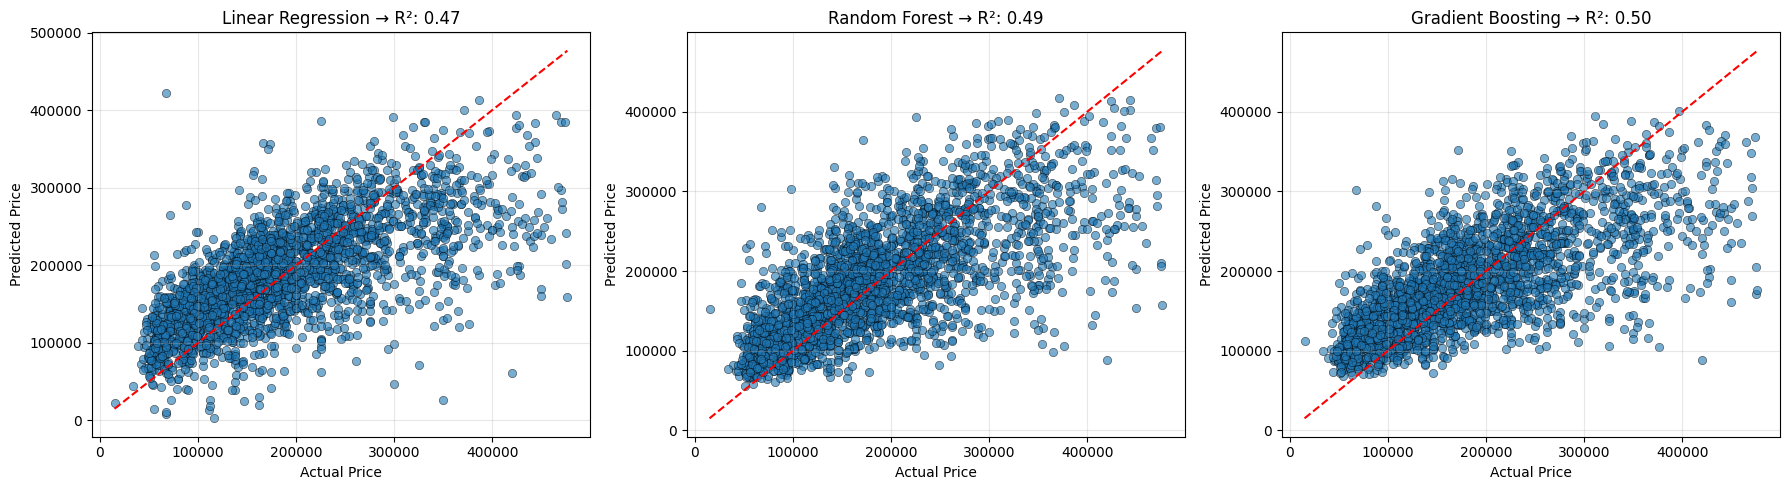

In [46]:
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb
}

plt.figure(figsize=(18, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, edgecolor='k')
    sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')
    plt.title(f"{name} → R²: {r2_score(y_test, preds):.2f}")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Evaluasi dari ketiga model di atas, maka dapat disimpulkan bahwa 'Gradient Boosting' merupakan model yang paling akurat dibanding model lainnya. Dia memiliki error yang terendah untuk MAE dan RMSE.Dan memiliki score R2 yang paling baik yaitu 0.50. Sangat direkomendasikan untuk production.

Performa terbaik kedua adalah 'Random Forest' dan di peringkat akhir adalah 'Linear Regression'

In [54]:
# Save model
joblib.dump(gb, 'gradient_boosting_model.joblib')

['gradient_boosting_model.joblib']

In [55]:
# Load model
gb_loaded = joblib.load('gradient_boosting_model.joblib')

In [57]:
# Test model
y_pred = gb_loaded.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

R² Score: 0.5003
MAE: 49004.9894
MAPE: 0.3164
MSE: 4263933250.9458
RMSE: 65298.7998


In [58]:
import os

# Cek di mana file tersimpan
current_dir = os.getcwd()
print(f"📁 Current directory: {current_dir}")

# List semua file .joblib dan .pkl
files = [f for f in os.listdir() if f.endswith(('.joblib', '.pkl'))]
print(f"\n📦 Model files found:")
for f in files:
    file_path = os.path.join(current_dir, f)
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
    print(f"   • {f} ({file_size:.2f} MB)")
    print(f"     Location: {file_path}")

📁 Current directory: /content

📦 Model files found:
   • gradient_boosting_model.joblib (0.14 MB)
     Location: /content/gradient_boosting_model.joblib


# 5. CONCLUSION

Berdasarkan pemodelan yang sudah dilakukan, fitur "median_income" dan "total_rooms" menjadi fitur yang paling berpengaruh terhadap "median_house_value".

Metriks evaluasi yang digunakan pada model adalah nilai MAE, MAPE, MSE, RMSE dan R². Hasil evaluasi dari tiga model yang dilakukan yaitu "Linear Regression", "Random Forest" dan "Gradient Boosting", maka performa terbaik pada use case ini adalah "Gradient Boosting" dimana hasil terbaik untuk R² adalah sebesar 0.50 dan MAPE sebesar 31.64%.



# 6. RECOMMENDATION

Nilai R² sebesar 50% dan MAPE sebesar 31.64% menjadi salah satu concern dari case ini. Perlu adanya perbaikan untuk meningkatkan nilai R² dan memperbaiki error MAPE.

Salah satu rekomendasi yang bisa dilakukan adalah dengan melakukan Feature Engineering, yaitu menambahkan fitur-fitur baru seperti Fitur interaksi (income_per_room, location_income) dan Fitur jarak (jarak ke San Fransisco, Jarak ke Los Angeles, Jarak ke pantai, dll).

Kemudian rekomendasi yang kedua adalah dengan melakukan Hyperparameter Tuning, misalkan dengan melakukan optimisasi pada "Gradient Boosting" model menggunakan GridSearchCV.